# Moran-Felsenszwalb multivariate spatial segmentation workflow

#### Demo notebook - February 2024 - LEM Tideman - TU Delft
#### Zebra-fish dataset

In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
from skimage.segmentation import felzenszwalb, mark_boundaries
from sklearn.preprocessing import minmax_scale
from skimage.measure import label
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
from moran_imaging.spatial_weights_matrix import define_spatial_weights_matrix
from moran_imaging.local_global_spatial_autocorrelation import MoranLocal
from moran_imaging.plotting import position_discrete_colorbar_ticks

In [3]:
# Seaborn plotting style
sns.set(style="whitegrid",font_scale=1.5)

colormap_scatterplot = ListedColormap(['#ff85a5', 'black', 'lightskyblue', 'white'])
colormap_scatterplot_binary = ListedColormap(['#ff85a5', 'lightskyblue'])

sns.set(style="whitegrid", font_scale=1)
colormap_reverse = sns.blend_palette([".99", "darkblue"], as_cmap=True)

In [4]:
def make_ion_image(data, image_shape, background_mask, fill_zeros=True, show_image=True, colormap='coolwarm'):
    
    # Fill background pixels with zeros (default) or NaN
    pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
    pixel_grid[np.invert(background_mask)] = data
    
    if not fill_zeros:
        pixel_grid[background_mask] = np.nan
    
    # Reshape data
    ion_image = np.reshape(pixel_grid, image_shape)
    
    # Plot ion image 
    if show_image == True: 
        plt.figure(dpi=100)
        plt.imshow(ion_image, cmap=colormap)
        plt.axis('off')
        plt.show()
        
    return ion_image

In [5]:
def kmeans_superpixel_coloring(segments, cluster_labels, num_pixels, background_mask): 
    
    segmentation_labels = label(segments).flatten()[np.invert(background_mask)]
    mapping_pixel_to_segment = segmentation_labels
    all_segment_labels = np.unique(mapping_pixel_to_segment)
    dict_segment_to_pixels = {}
    for segment_label in all_segment_labels: 
        dict_segment_to_pixels[segment_label] = mapping_pixel_to_segment == segment_label

    segment_label_dict = {}
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        pixel_labels_segment = cluster_labels[mask_segment]
        cluster_segment_label = stats.mode(pixel_labels_segment)[0]
        segment_label_dict[segment_label] = cluster_segment_label

    final_cluster_labels = np.zeros(num_pixels)
    for segment_label in all_segment_labels: 
        mask_segment = dict_segment_to_pixels[segment_label]
        final_cluster_labels[mask_segment] = segment_label_dict[segment_label]
        
    return final_cluster_labels

### Load imaging mass spectrometry data

In [6]:
with open('./Data/Zebra_fish_PCA_dataset.pickle', 'rb') as handle:
    zebra_fish_dict = pickle.load(handle)

image_shape = zebra_fish_dict['image_shape'] 
background_mask = zebra_fish_dict['background_mask'] 
pixel_order = zebra_fish_dict['pixel_order']  
dataset_PCA = zebra_fish_dict['dataset_PCA'] 
acquisition_mask = np.invert(background_mask)
num_pixels = dataset_PCA.shape[0]

C:\Users\Leo\AppData\Local\Temp\ipykernel_28160\654732082.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  zebra_fish_dict = pickle.load(handle)


In [7]:
# Definition of the spatial weights matrix
weights_matrix = define_spatial_weights_matrix(image_shape, 'Queen', 5, background_mask, with_lower_order=True)
weights_matrix.transform = "r"

In [8]:
# Computation of one Moran quadrant map per principal component
Dict_Moran_quadrants = {}

ion_image_with_background_PC1 = make_ion_image(dataset_PCA[:, 0], image_shape, background_mask, show_image=False, fill_zeros=True)
local_Moran_object_PC1 = MoranLocal(ion_image_with_background_PC1.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC1 = local_Moran_object_PC1.quadrant.astype(float)
Dict_Moran_quadrants[0] = Moran_quadrants_PC1[acquisition_mask]

ion_image_with_background_PC2 = make_ion_image(dataset_PCA[:, 1], image_shape, background_mask, show_image=False, fill_zeros=True)
local_Moran_object_PC2 = MoranLocal(ion_image_with_background_PC2.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC2 = local_Moran_object_PC2.quadrant.astype(float)
Dict_Moran_quadrants[1] = Moran_quadrants_PC2[acquisition_mask]

ion_image_with_background_PC3 = make_ion_image(dataset_PCA[:, 2], image_shape, background_mask, show_image=False, fill_zeros=True)
local_Moran_object_PC3 = MoranLocal(ion_image_with_background_PC3.astype("float64"), weights_matrix, background_mask, 999, 52)
Moran_quadrants_PC3 = local_Moran_object_PC3.quadrant.astype(float)
Dict_Moran_quadrants[2] = Moran_quadrants_PC3[acquisition_mask]

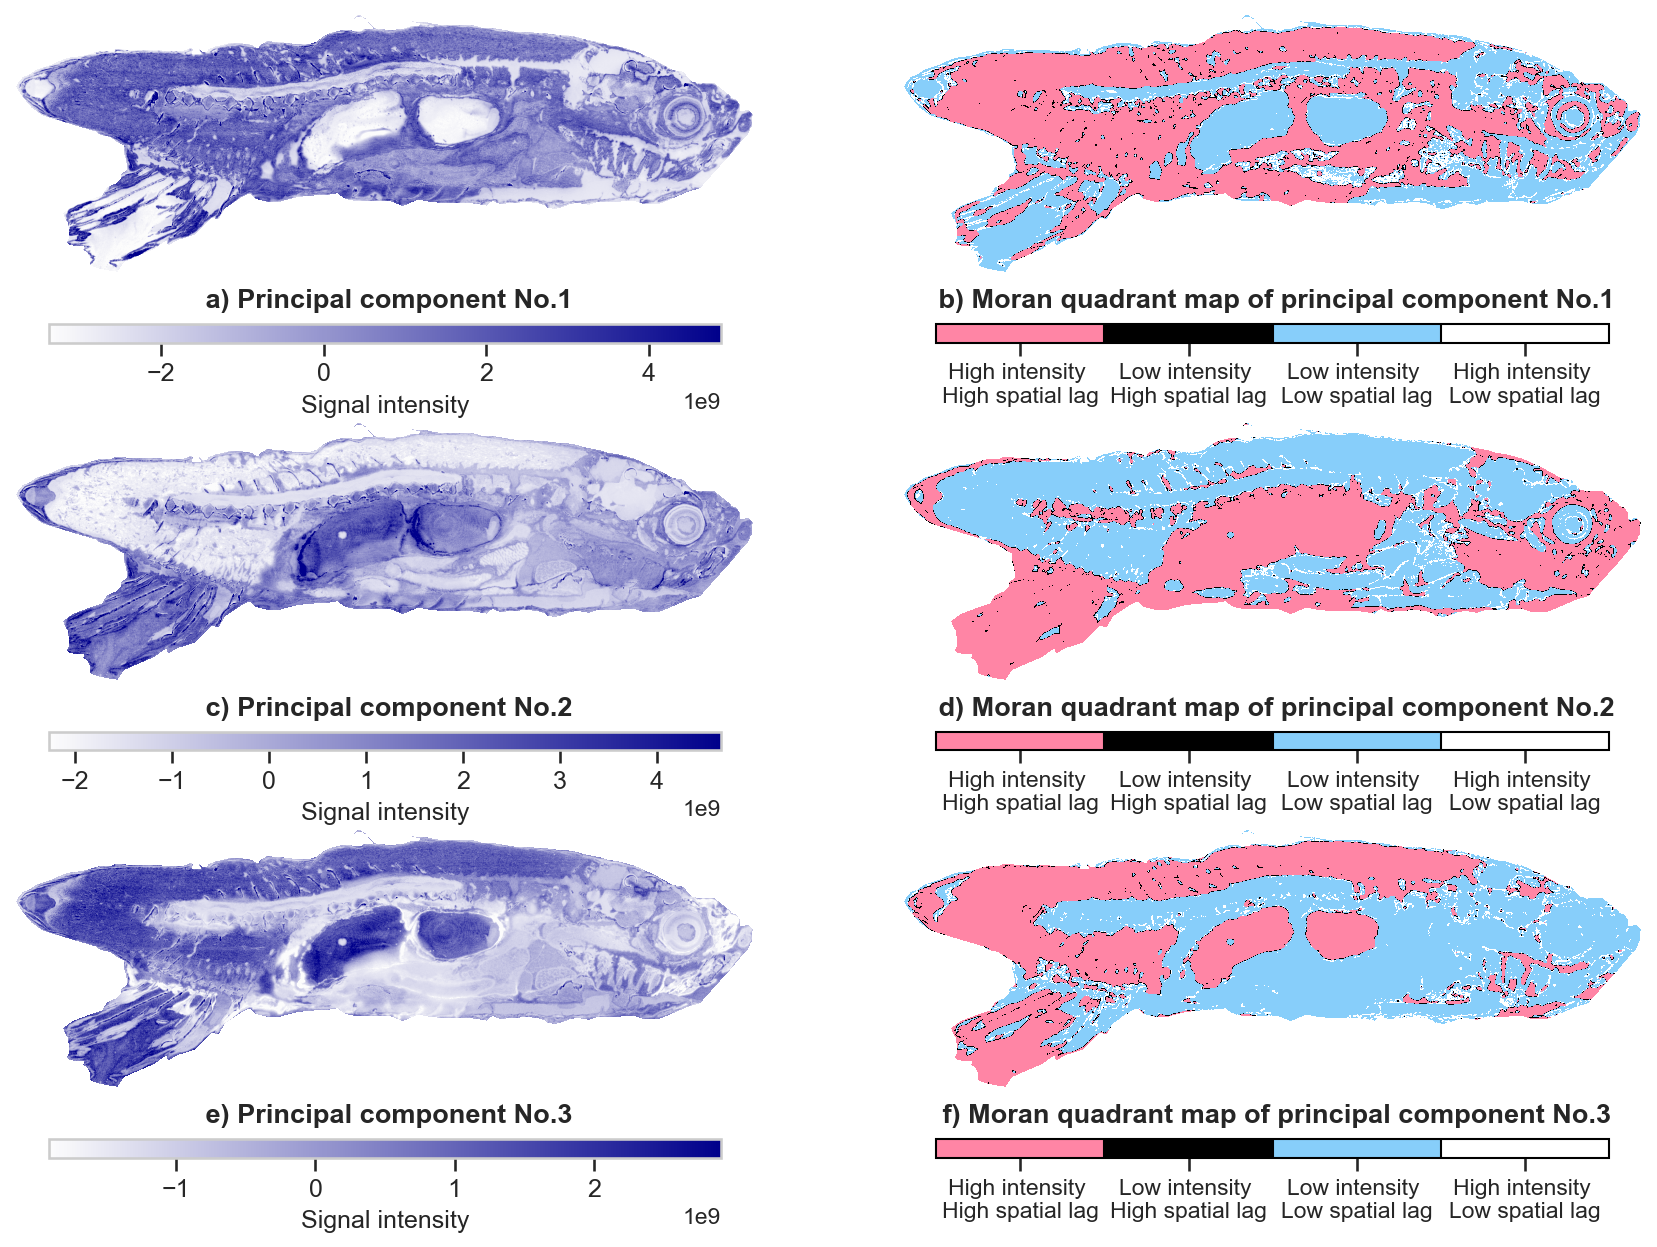

In [9]:
demo_list = [0, 1, 2]
fig = plt.figure(figsize=(14, 10), dpi=150)
gridspec = plt.GridSpec(3, 2)
plt.tight_layout()

for ax_index, feature_index in enumerate(demo_list):
    letters = ["a", "c", "e"]
    axes_mini = fig.add_subplot(gridspec[ax_index, 0])
    ion_image = make_ion_image(dataset_PCA[:, feature_index], image_shape, background_mask, fill_zeros=False, show_image=False)
    
    mini_fig = axes_mini.imshow(ion_image, vmin=np.nanpercentile(ion_image, 1), vmax=np.nanpercentile(ion_image, 99), cmap=colormap_reverse)
    axes_mini.set_title("\n " + letters[ax_index] + ") Principal component No." + str(feature_index+1), y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    cbar = fig.colorbar(mini_fig, ax=axes_mini, orientation="horizontal", fraction=0.055, pad=0.15, aspect=36)
    cbar.set_label("Signal intensity")
    cbar.ax.tick_params(labelsize=12)

for ax_index, feature_index in enumerate(demo_list):
    letters = ["b", "d", "f"]
    axes_mini = fig.add_subplot(gridspec[ax_index, 1])
    Moran_quadrants = Dict_Moran_quadrants[feature_index]
    Moran_quadrant_map = make_ion_image(Moran_quadrants, image_shape, background_mask, fill_zeros=False, show_image=False) 
    
    mini_fig = axes_mini.imshow(Moran_quadrant_map, cmap=colormap_scatterplot, interpolation=None) 
    axes_mini.set_title("\n " + letters[ax_index] + ") Moran quadrant map of principal component No." + str(feature_index+1), y=-0.18, fontsize=13, fontweight="bold")
    axes_mini.axis("off")
    
    tick_labels = ['High intensity \n'+'High spatial lag', 'Low intensity \n'+'High spatial lag', 'Low intensity \n'+'Low spatial lag', 'High intensity \n'+'Low spatial lag']
    tick_loc = position_discrete_colorbar_ticks(1, 4)
    cbar_total = plt.colorbar(mini_fig, ax=axes_mini, ticks=tick_loc, orientation='horizontal', fraction=0.055, pad=0.15, aspect=36, drawedges=True)
    cbar_total.ax.set_xticklabels(tick_labels)
    cbar_total.outline.set_color('black')
    cbar_total.dividers.set_color('black')
    cbar_total.dividers.set_linewidth(1)
    cbar_total.outline.set_linewidth(1)

fig.savefig("./Figures/Figure_7", bbox_inches="tight")
plt.show()

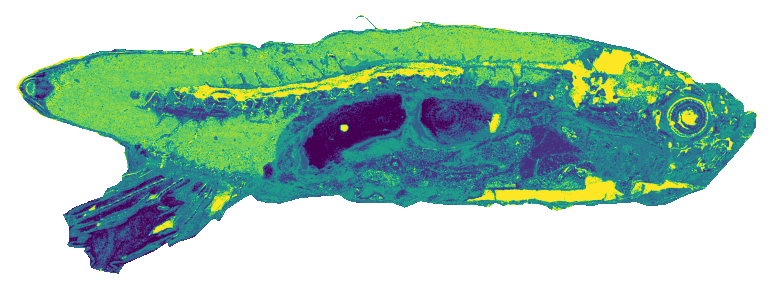

In [10]:
# Pixel-wise k-means clustering
num_clusters = 8 
cluster_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init='auto', random_state=1)
cluster_model.fit(dataset_PCA)
cluster_labels = cluster_model.labels_

# Plot clustering results
pixel_grid = np.zeros((image_shape[0]*image_shape[1], ))
pixel_grid[np.invert(background_mask)] = cluster_labels
pixel_grid[background_mask] = np.nan
ion_image = np.reshape(pixel_grid, image_shape)

plt.figure(dpi=150)
plt.imshow(ion_image, cmap='viridis')
plt.axis('off')

plt.savefig("./Figures/Figure_8a", bbox_inches="tight")
plt.show()

In [11]:
# Segmentation of principal component maps
baseline_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.float32)

PC1_scale = minmax_scale(dataset_PCA[:, 0], feature_range=(0, 1))
PC2_scale = minmax_scale(dataset_PCA[:, 1], feature_range=(0, 1))
PC3_scale = minmax_scale(dataset_PCA[:, 2], feature_range=(0, 1))

baseline_image[:, :, 0] = make_ion_image(PC1_scale, image_shape, background_mask, fill_zeros=False, show_image=False)
baseline_image[:, :, 1] = make_ion_image(PC2_scale, image_shape, background_mask, fill_zeros=False, show_image=False)
baseline_image[:, :, 2] = make_ion_image(PC3_scale, image_shape, background_mask, fill_zeros=False, show_image=False)

segments_baseline = felzenszwalb(baseline_image, scale=50, sigma=0.2, min_size=100)
segments_baseline_flat = segments_baseline.flatten()[acquisition_mask]

segmentation_boundaries = mark_boundaries(baseline_image[:, :, 0], segments_baseline)
non_spatial_segmentation_boundaries_no_background = np.zeros(segmentation_boundaries.shape)
non_spatial_segmentation_boundaries_no_background[:, :, 0] = make_ion_image(segmentation_boundaries[:, :, 0].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)
non_spatial_segmentation_boundaries_no_background[:, :, 1] = make_ion_image(segmentation_boundaries[:, :, 1].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)
non_spatial_segmentation_boundaries_no_background[:, :, 2] = make_ion_image(segmentation_boundaries[:, :, 2].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)

print(f'Number of segments with non-spatial segmentation approach: {len(np.unique(segments_baseline))}')

Number of segments with non-spatial segmentation approach: 2808


In [12]:
# Segmentation of Moran quadrant maps
PCs_like_RGB = np.zeros((image_shape[0], image_shape[1], 3))
PCs_like_RGB[:, :, 0] = make_ion_image(Dict_Moran_quadrants[0], image_shape, background_mask, fill_zeros=False, show_image=False) 
PCs_like_RGB[:, :, 1] = make_ion_image(Dict_Moran_quadrants[1], image_shape, background_mask, fill_zeros=False, show_image=False) 
PCs_like_RGB[:, :, 2] = make_ion_image(Dict_Moran_quadrants[2], image_shape, background_mask, fill_zeros=False, show_image=False) 

segments_moran = felzenszwalb(PCs_like_RGB, scale=50, sigma=0.2, min_size=100)
segments_moran_flat = segments_moran.flatten()[acquisition_mask]

segmentation_boundaries = mark_boundaries(baseline_image[:, :, 0], segments_moran)
spatial_segmentation_boundaries_no_background = np.zeros(segmentation_boundaries.shape)
spatial_segmentation_boundaries_no_background[:, :, 0] = make_ion_image(segmentation_boundaries[:, :, 0].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)
spatial_segmentation_boundaries_no_background[:, :, 1] = make_ion_image(segmentation_boundaries[:, :, 1].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)
spatial_segmentation_boundaries_no_background[:, :, 2] = make_ion_image(segmentation_boundaries[:, :, 2].flatten()[acquisition_mask], image_shape, background_mask, fill_zeros=False, show_image=False)

print(f'Number of segments with spatial segmentation approach: {len(np.unique(segments_moran))}')

Number of segments with spatial segmentation approach: 2227


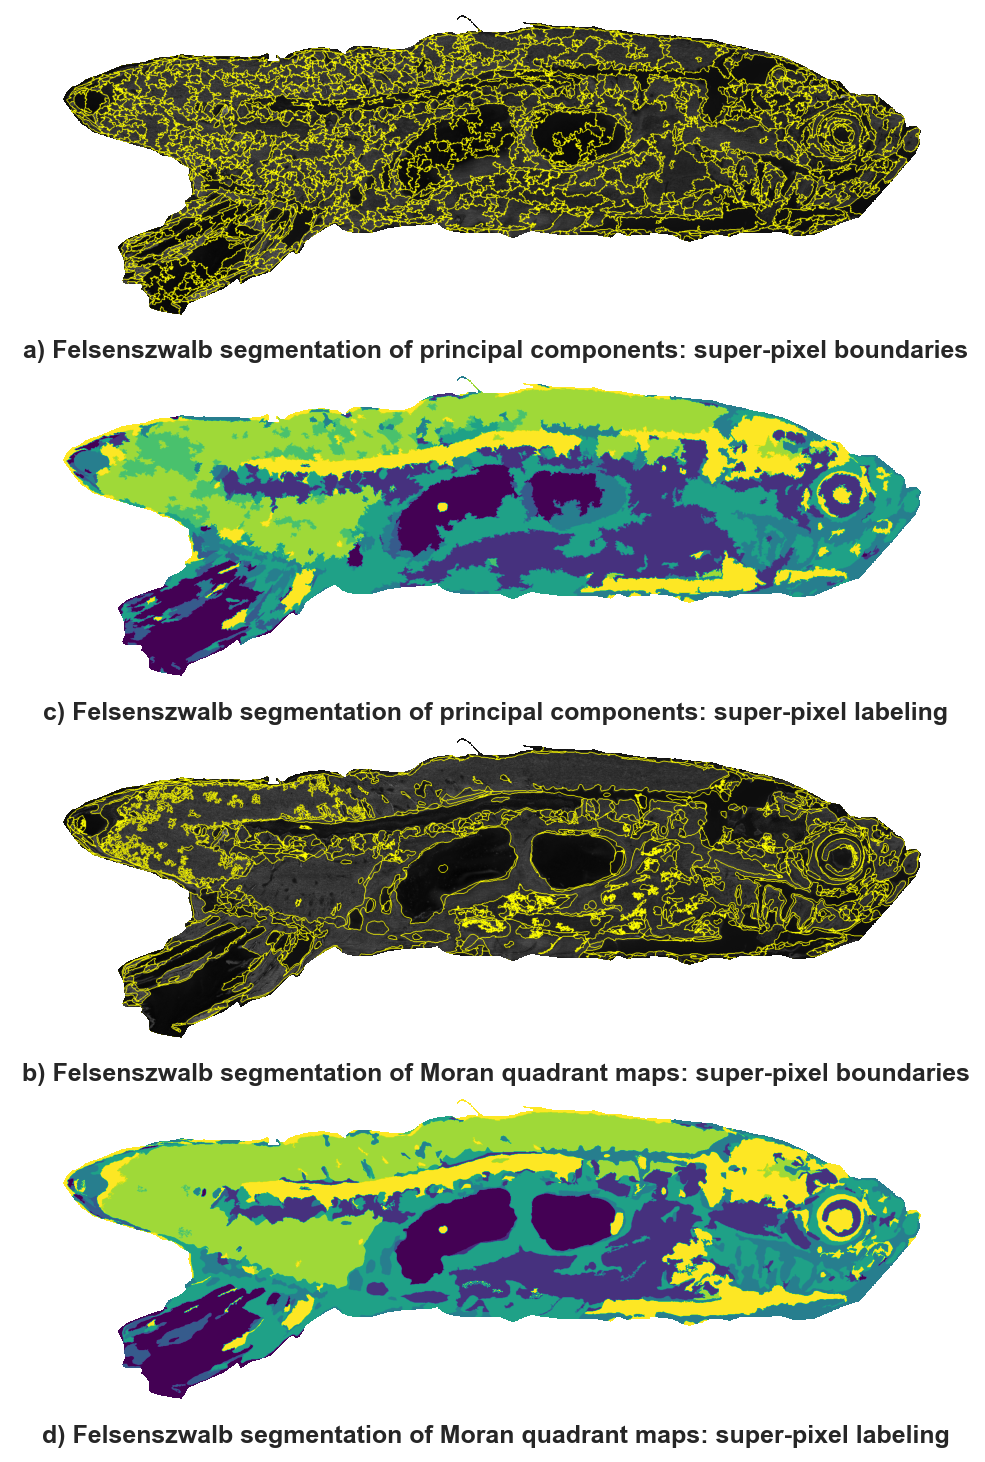

In [13]:
fig = plt.figure(figsize=(8, 12), dpi=150)
gridspec = plt.GridSpec(4, 1)
plt.tight_layout()

axes_mini = fig.add_subplot(gridspec[0])
mini_fig = axes_mini.imshow(non_spatial_segmentation_boundaries_no_background, interpolation=None, cmap='Greys')
axes_mini.set_title("\n a) Felsenszwalb segmentation of principal components: super-pixel boundaries", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

axes_mini = fig.add_subplot(gridspec[1])
final_cluster_labels_non_spatial = kmeans_superpixel_coloring(segments_baseline, cluster_labels, num_pixels, background_mask)
final_cluster_labels_non_spatial = make_ion_image(final_cluster_labels_non_spatial, image_shape, background_mask, fill_zeros=False, show_image=False)
mini_fig = axes_mini.imshow(final_cluster_labels_non_spatial, cmap='viridis')
axes_mini.set_title("\n c) Felsenszwalb segmentation of principal components: super-pixel labeling", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

axes_mini = fig.add_subplot(gridspec[2])
mini_fig = axes_mini.imshow(spatial_segmentation_boundaries_no_background, interpolation=None, cmap='Greys')
axes_mini.set_title("\n b) Felsenszwalb segmentation of Moran quadrant maps: super-pixel boundaries", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

axes_mini = fig.add_subplot(gridspec[3])
final_cluster_labels_spatial = kmeans_superpixel_coloring(segments_moran, cluster_labels, num_pixels, background_mask)
final_cluster_labels_spatial = make_ion_image(final_cluster_labels_spatial, image_shape, background_mask, fill_zeros=False, show_image=False)
mini_fig = axes_mini.imshow(final_cluster_labels_spatial, cmap='viridis')
axes_mini.set_title("\n d) Felsenszwalb segmentation of Moran quadrant maps: super-pixel labeling", y=-0.18, fontsize=12, fontweight="bold")
axes_mini.axis("off")

fig.savefig("./Figures/Figure_9", bbox_inches="tight")
plt.show()